In [53]:
# import...

import xarray as xr
import os
import pandas as pd
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt
from geopy import distance
import scipy.stats as stats

os.chdir("/Users/etmu9498/research/code/scripts")
import helper_fns
import make_plots
os.chdir("/Users/etmu9498/research/code/scripts/boundary-layer")
import boundary_layer_scripts

In [54]:
# find z_i, the thermodynamic mixed layer depth, using zhang's definition:
# z_i = the height where theta_v increases by .5 k from the mean value of data from the lowest 150m
def findzi( z, thetav):
        
    # trim heights and temps to values under 150 m!
    z150 = z[ np.where( z <= 150.0 )]
    thetav150 = thetav[ np.where( z <= 150.0 )]

    # find the mean virt pot temp value below 150m
    mean_thetav = np.nanmean( thetav150)
    
    # search through thetas above 150m for values more than .5 K > mean theta
    # the first one found ( lowest one) is the mixed layer height!
    thetav_above150 = thetav[ np.where( z > 150.0 )]
    z_above150 = z[ np.where( z > 150.0 )]

    # reverse matrices to cycle through lowest values first
    thetav_above150 = np.flip( thetav_above150)
    z_above150 = np.flip( z_above150)
    
    # iterate through values
    for i in range( len( thetav_above150)):
     
        # check if value passes the temperature threshold!
        # return case
        if thetav_above150[i] >= mean_thetav + .5:
            theta_i = thetav_above150[i]
            z_i = z_above150[i]
            return theta_i, z_i
        

In [55]:
# load crl data and find crl theta and thetav
crl_path = "/Users/etmu9498/research/data/CRL_data/2021"
crl_list = make_plots.load_crl( crl_path, print_files=False)
crl_name = crl_list[ 18]
os.chdir( crl_path)
crl_data = xr.open_dataset( crl_name)

newh, crl_theta, crl_thetav = boundary_layer_scripts.find_theta_thetav( tcname='sam', dataset=5)

print( np.shape( crl_theta))

tc_center = (20.375, -57.85)

correcting crl heights
temperature interpolated
water vapor interpolated
creating pressure matrix
(9300, 667)


In [56]:
# fill these lists through iteration
zi_times = []
x = [] # distance from TC center
z_i = [] # mixed layer height

# iterate through all the thousands of crl profiles! look for ones reaching the bottom 150m of the boundary layer
for i in range( len( crl_data.time)):
    
    z = - newh * 1000
    thetav = crl_thetav[ i, :]
    
    # trim temps to values under 150 m! are there values?
    thetav150 = thetav[ np.where( z <= 25.0 )]
    thetav150 = thetav150[ np.where( ~ np.isnan( thetav150))]
    
    # print( thetav150)
    
    
    # there's data below 150 m case! 
    if len( thetav150) > 0:
        
        theta_i, zind = findzi( z, thetav)

        z_i.append( round( zind, 4))
        
        # find distances for this case!
        # rename lat and lon variables
        lat = crl_data.Lat[i].values
        lon = crl_data.Lon[i].values

        # use the first lat and lon values, as these are closest to the plane's orig location!
        sonde_loc = ( lat, lon)

        # calculate the distance from the tc center using geopy!
        dist = distance.distance( sonde_loc, tc_center).km
        x.append( round( dist, 4))

        # save the times of each valid point
        zi_times.append( float( crl_data.time[ i].values))
        
        
        
    if i % 500 == 0:
        print("case " + str(i) + " completed")

case 0 completed
case 500 completed
case 1000 completed
case 1500 completed
case 2000 completed
case 2500 completed
case 3000 completed
case 3500 completed
case 4000 completed
case 4500 completed
case 5000 completed
case 5500 completed
case 6000 completed
case 6500 completed
case 7000 completed
case 7500 completed
case 8000 completed
case 8500 completed
case 9000 completed


In [29]:
# find distance from tc center for all crl data points (copy code above)
center_dists = []

for i in range( len( crl_data.time)):
    lat = crl_data.Lat[i].values
    lon = crl_data.Lon[i].values
    sonde_loc = ( lat, lon)

    center_dists.append(distance.distance( sonde_loc, tc_center).km )
        
    if i % 500 == 0:
        print("case " + str(i) + " completed")

case 0 completed
case 500 completed
case 1000 completed
case 1500 completed
case 2000 completed
case 2500 completed
case 3000 completed
case 3500 completed
case 4000 completed
case 4500 completed
case 5000 completed
case 5500 completed
case 6000 completed
case 6500 completed
case 7000 completed
case 7500 completed
case 8000 completed
case 8500 completed
case 9000 completed


In [35]:
# testing

print( len(x))
print( len( z_i))
print( len( zi_times))
print( x[0:10])
print( z_i[0:10])
print( zi_times[0:10])

print( len( center_dists))

strlist = [ str( item) for item in center_dists]
print( len( strlist))
print( strlist[0:10])

1607
1607
1607
[206.8601, 203.5168, 203.2699, 200.1025, 195.7508, 195.5056, 195.2958, 195.0468, 194.8457, 194.5889]
[814.0, 226.0, 196.0, 256.0, 328.0, 1408.0, 1390.0, 316.0, 292.0, 274.0]
[21.21150016784668, 21.21929931640625, 21.219900131225586, 21.22760009765625, 21.23819923400879, 21.238800048828125, 21.239299774169922, 21.239900588989258, 21.240400314331055, 21.240999221801758]
9300
9300
['212.06531094656316', '211.785865482998', '211.54863463539942', '211.26906153480584', '211.03653643863382', '210.75413017365452', '210.4734601388845', '210.234866228569', '209.9540534952297', '209.71879915825593']


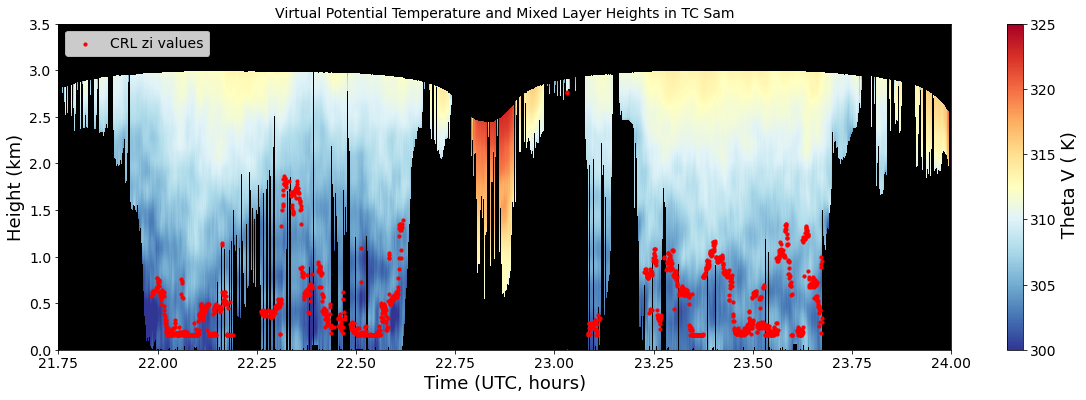

In [47]:
# plot mixed layer heights over CRL potential temp data

# plot temp data
plt.figure( figsize=(20, 6))
lims = [21.75, 24]

helper_fns.change_font_sizes()

# plt.locator_params(axis='x', nbins=11)

color_map = plt.cm.get_cmap( "RdYlBu").reversed()
plt.pcolormesh( crl_data.time, - newh, crl_thetav.transpose(), cmap = color_map, vmin=300, vmax=325 )

plt.ylabel( 'Height (km)')
plt.xlabel('Time (UTC, hours)')


plt.xlim( lims)
plt.ylim([0, 3.5])

ax = plt.gca()
ax.set_facecolor('k')
plt.colorbar(label=" Theta V ( K)")

# plot zi heights atop temp data
plt.scatter( zi_times, np.array( z_i) / 1000, c='r', s=10, label="CRL zi values")
plt.legend(loc='upper left')

plt.title( "Virtual Potential Temperature and Mixed Layer Heights in TC Sam")

plt.locator_params(axis='x', nbins=11)

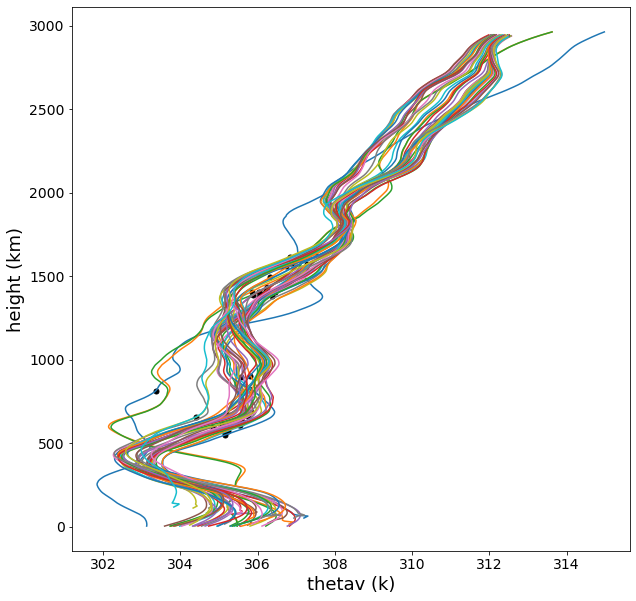

In [57]:
# make a figure to see what theta profiles look like
plt.figure( figsize=(10, 10))
plt.ylabel( 'height (km)')
plt.xlabel( 'thetav (k)')

cutoff = 150

# plot lines first
for i in range( 5000): # len( crl_data.time)):
    
    z = - newh * 1000
    thetav = crl_thetav[ i, :]
    
    # trim temps to values under 150 m! are there values?
    thetav150 = thetav[ np.where( z <= cutoff )]
    thetav150 = thetav150[ np.where( ~ np.isnan( thetav150))]
    
    # there's data below 150 m case! 
    if len( thetav150) > 0:        
        continue# plt.plot( thetav, z)
        
# plot scatter point heights second
for i in range( 1000): # len( crl_data.time)):
    
    z = - newh * 1000
    thetav = crl_thetav[ i, :]
    
    # trim temps to values under 150 m! are there values?
    thetav150 = thetav[ np.where( z <= cutoff )]
    thetav150 = thetav150[ np.where( ~ np.isnan( thetav150))]
    
    # there's data below 150 m case! 
    if len( thetav150) > 0:
        
        theta_i, zind = findzi( z, thetav)
        
        if zind > 500:
            plt.scatter( theta_i, zind, c='k', s=25)
            plt.plot(thetav, z)


In [49]:
print( len( x))
print( len( z_i))

# print( x)
# print( z_i)

1607
1607


Subplot 1 R^2 = 0.019738750580159836


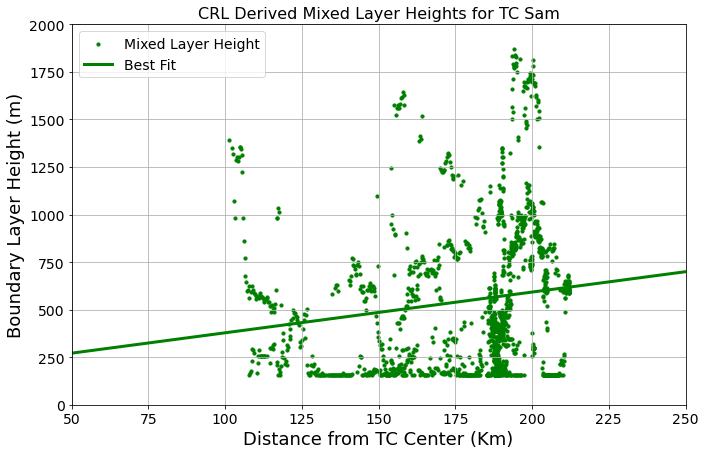

In [58]:
plt.figure( figsize=(11, 7))

helper_fns.change_font_sizes()
plt.xlabel( "Distance from TC Center (Km)")
plt.ylabel( "Boundary Layer Height (m)")
plt.grid('on')
plt.title( "CRL Derived Mixed Layer Heights for TC Sam", fontsize=16)
plt.scatter( x, z_i, c='g', s=10, label='Mixed Layer Height')


# best fit for plot 1
slope, intercept, r, p, se = stats.linregress(  x, z_i)
best_fit_x = np.linspace( 0, 500, 500)
best_fit_y = slope * best_fit_x + intercept
plt.plot( best_fit_x, best_fit_y, c='g', linewidth=3, label='Best Fit')
plt.legend()

plt.xlim( [50, 250])
plt.ylim( [0, 2000])

print("Subplot 1 R^2 = " + str( r**2))
